# Setup my environment

In [1]:
# Googel Drive
# from google.colab import drive
# drive.mount('/content/drive')
# kaggel
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d apollo2506/satellite-imagery-of-ships

Saving kaggle.json to kaggle.json
 89% 41.0M/45.8M [00:01<00:00, 22.4MB/s]
100% 45.8M/45.8M [00:01<00:00, 26.9MB/s]


In [2]:
import zipfile
with zipfile.ZipFile('/content/satellite-imagery-of-ships.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/satallite_Dataset')

## import Libraries

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
#
import os
import random
from tqdm import tqdm
#
import imgaug.augmenters as iaa
#
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
# from keras.models import load_model
#
import warnings
warnings.filterwarnings('ignore')

# My Functions

In [4]:
class cCreate_DataSets:

    def __init__(self, DataPath):
        self.DataPath = DataPath
        self.categories = { 'no-ship':0,  'ship':1}
        # Augmentation for balancing class 1
        self.seq_class1_rotate = iaa.Sequential([ iaa.Affine(rotate=(-20, 20))])# rotate
        self.seq_class1_HS = iaa.Sequential([iaa.AddToHueAndSaturation(value=(-20, 20))]) # Change hue and saturation
        self.seq_class1_Scale = iaa.Sequential([iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})])# Scale in x and y direction

    #
    #
    def augment_image(self, image, class_num):
        if class_num == 1:
            temp_ro=image.copy()
            temp_HS=image.copy()
            temp_sc=image.copy()

            temp_ro= self.seq_class1_rotate.augment_image(temp_ro)
            temp_HS= self.seq_class1_HS.augment_image(temp_HS)
            temp_sc= self.seq_class1_Scale.augment_image(temp_sc)

            return temp_ro,temp_HS,temp_sc
        else:
            return image
    #
    #
    def Create_Raw_Image(self, arrayDataSet):
        for clas,encode in self.categories.items():
            CAT_PATH = os.path.join(self.DataPath, clas)
            for imgs in tqdm(os.listdir(CAT_PATH)):
                try:
                    img = cv2.imread(os.path.join(CAT_PATH, imgs))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if encode == 1 :
                      img_ro,img_hs,img_sc = self.augment_image(img, encode)

                      img_ro=img_ro.astype('float32')/255.0  # Normalization
                      img_hs=img_hs.astype('float32')/255.0  # Normalization
                      img_sc=img_sc.astype('float32')/255.0  # Normalization

                      arrayDataSet.append([img_ro, encode])
                      arrayDataSet.append([img_hs, encode])
                      arrayDataSet.append([img_sc, encode])

                    img = img.astype('float32')/255.0  # Normalization
                    arrayDataSet.append([img, encode])
                except Exception as e:
                    print(e)

        return arrayDataSet
    #
    #
    def Create_GaussianProc_Image(self, arrayDataSet):
        for  clas,encode in self.categories.items():
            CAT_PATH = os.path.join(self.DataPath, clas)
            for imgs in tqdm(os.listdir(CAT_PATH)):
                try:
                    img = cv2.imread(os.path.join(CAT_PATH, imgs))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    blurred = cv2.GaussianBlur(img, (3, 3), 0)  # Smoothing Edges
                    if encode == 1 :
                      img_ro,img_hs,img_sc = self.augment_image(blurred, encode)

                      img_ro=img_ro.astype('float32')/255.0  # Normalization
                      img_hs=img_hs.astype('float32')/255.0  # Normalization
                      img_sc=img_sc.astype('float32')/255.0  # Normalization

                      arrayDataSet.append([img_ro, encode])
                      arrayDataSet.append([img_hs, encode])
                      arrayDataSet.append([img_sc, encode])

                    blurred = blurred.astype('float32')/255.0  # Normalization
                    arrayDataSet.append([blurred, encode])
                except Exception as e:
                    print(e)
        return arrayDataSet


In [5]:
def imread(path):
    imbgr = cv2.imread(path)
    return cv2.cvtColor(imbgr, cv2.COLOR_BGR2RGB)  # retern img rgb


def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()


def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def rgb2bin(img):
    t, imbin = cv2.threshold(rgb2gray(img), 0, 255,cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    return imbin

In [54]:
class cDraw:

  def __init__(self ):
    self.classes_names = { 0:'no-ship', 1: 'ship'}
  #
  #
  def draw_imgClass (self,img,classCode):
    print('Class : ' ,self.classes_names[classCode])
    plt.imshow(img, cmap='gray')
    plt.show()
  #
  #
  def draw_history(self,history):
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show()
  #
  #
  def Draw_Rec(self,img,clas,colorRec):
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Smoothing Edges
    components = cv2.connectedComponentsWithStats(
      rgb2bin(img), connectivity=4)
    (nLabels, labels, stats, centroids) = components
    centroids = centroids.astype(int)
    img_d = img.copy()

    for i in range(0, 1):
        x, y, w, h, area = stats[i]
        cv2.rectangle(img_d, (x, y), (x+w-1, y+h-1), colorRec, 1)
        cv2.putText(img_d, clas, (x+1, y+h-3), cv2.FONT_HERSHEY_SIMPLEX, 0.35, colorRec, 1)
    return img_d


In [55]:
def NO_classes (df):
  NO_ship=0
  NO_noShip=0
  for d,i in df:
    if i == 0:
      NO_noShip +=1
    else:
      NO_ship +=1

  print(f' Total Images = {len(df) }')
  print(f' Number of Images class No ship = {NO_noShip}')
  print(f' Number of Images class ship = {NO_ship}')

def TestFunction(ImgPath):
    objDraw=cDraw()
    test_image = imread(ImgPath)
    test_d =test_image.copy()

    test_image=np.asarray(test_image, dtype= np.float32)
    test_image=test_image/255

    test_image= np.expand_dims(test_image,0)
    result=model.predict(test_image)

    if result[0][0] < result[0][1]:
        clas = "ship"
        colorRec= (0,255,0)
    else:
        clas = "no ship"
        colorRec= (255,0,0)

    imshow(objDraw.Draw_Rec(test_d,clas,colorRec))

# Read Data

In [8]:
DATA_SET_PATH = r'/content/satallite_Dataset'

In [58]:
# create objects
objCreateData = cCreate_DataSets(DATA_SET_PATH)
objDraw = cDraw()


## Data Raw

In [10]:
objCreateData.categories

{'no-ship': 0, 'ship': 1}

In [11]:
dataSet=[]
dataSet=objCreateData.Create_Raw_Image(dataSet)

100%|██████████| 1000/1000 [00:02<00:00, 344.77it/s]


In [12]:
NO_classes(dataSet)

 Total Images = 7000
 Number of Images class No ship = 3000
 Number of Images class ship = 4000


Class :  no-ship


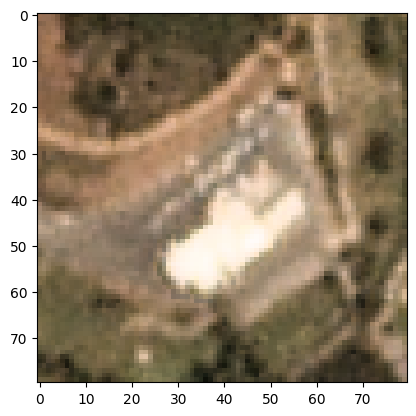

In [13]:
clsCdoe = dataSet[500][1]
imgRaw = dataSet[500][0]

objDraw.draw_imgClass(imgRaw,clsCdoe)

Class :  ship


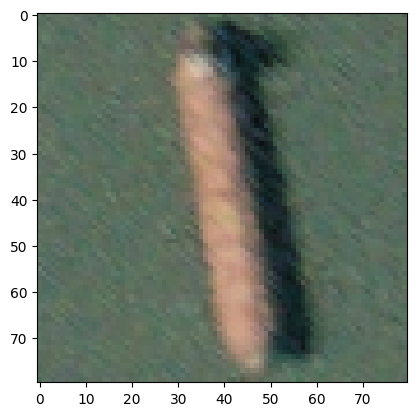

In [14]:
# original img
clsCdoe = dataSet[3051][1]
imgRaw = dataSet[3051][0]
objDraw.draw_imgClass(imgRaw,clsCdoe)

Class :  ship


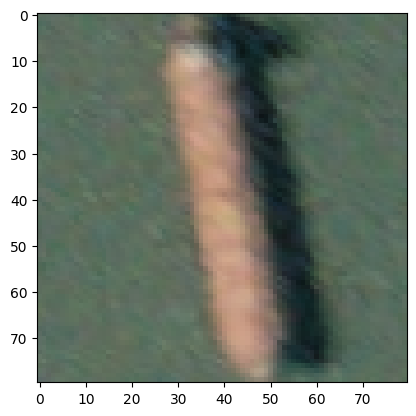

In [15]:
# scaled img
clsCdoe = dataSet[3050][1]
imgRaw = dataSet[3050][0]
objDraw.draw_imgClass(imgRaw,clsCdoe)

Class :  ship


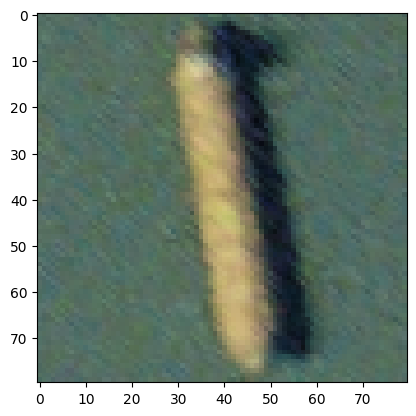

In [16]:
# hue and saturation img
clsCdoe = dataSet[3049][1]
imgRaw = dataSet[3049][0]
objDraw.draw_imgClass(imgRaw,clsCdoe)

Class :  ship


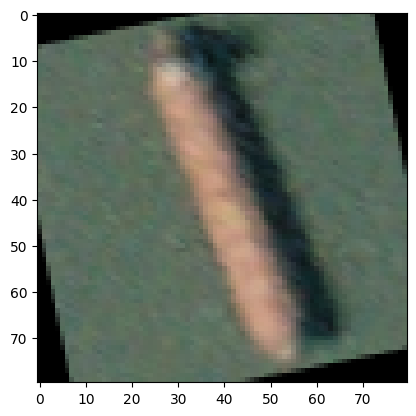

In [17]:
# rotate img
clsCdoe = dataSet[3048][1]
imgRaw = dataSet[3048][0]

objDraw.draw_imgClass(imgRaw,clsCdoe)

## Gaussian Process

In [18]:
dataGauss=[]
dataGauss=objCreateData.Create_GaussianProc_Image(dataGauss)


100%|██████████| 1000/1000 [00:03<00:00, 331.21it/s]


In [19]:
NO_classes(dataGauss)

 Total Images = 7000
 Number of Images class No ship = 3000
 Number of Images class ship = 4000


Class :  no-ship


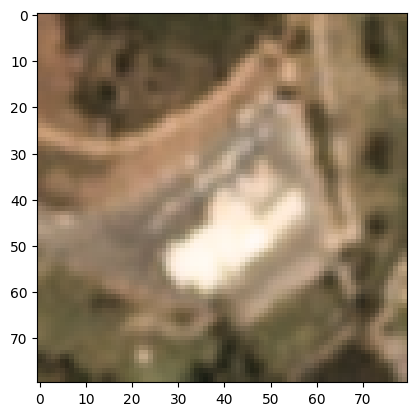

In [20]:
clsCdoe = dataGauss[500][1]
imgRaw = dataGauss[500][0]

objDraw.draw_imgClass(imgRaw,clsCdoe)

Class :  ship


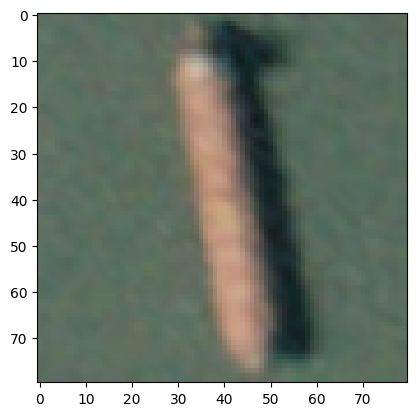

In [21]:
# original img
clsCdoe = dataGauss[3051][1]
imgRaw = dataGauss[3051][0]
objDraw.draw_imgClass(imgRaw,clsCdoe)

Class :  ship


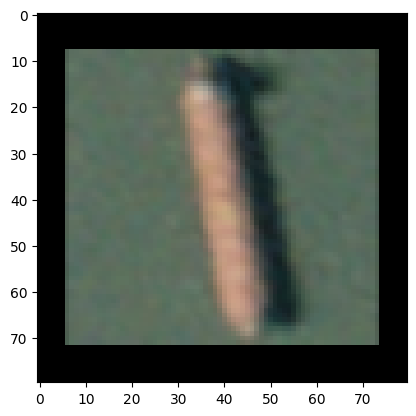

In [22]:
# scaled img
clsCdoe = dataGauss[3050][1]
imgRaw = dataGauss[3050][0]
objDraw.draw_imgClass(imgRaw,clsCdoe)

Class :  ship


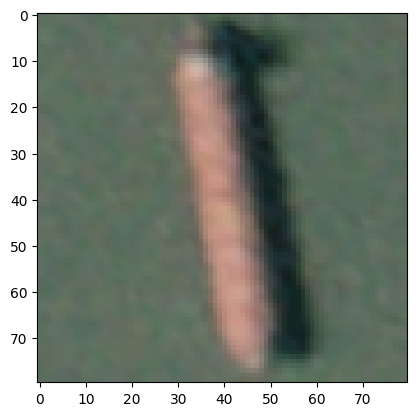

In [23]:
# hue and saturation img
clsCdoe = dataGauss[3049][1]
imgRaw = dataGauss[3049][0]
objDraw.draw_imgClass(imgRaw,clsCdoe)

Class :  ship


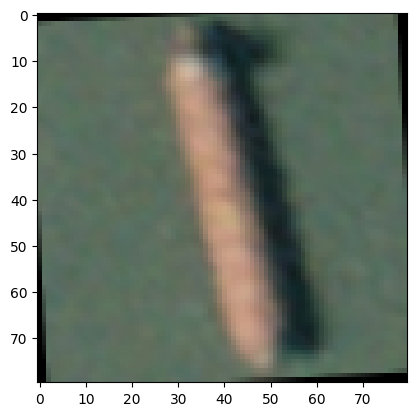

In [24]:
# rotate img
clsCdoe = dataGauss[3048][1]
imgRaw = dataGauss[3048][0]

objDraw.draw_imgClass(imgRaw,clsCdoe)

## Split Data

In [25]:
random.shuffle(dataGauss)
X_Gauss=[]
Y_Gauss=[]
for feature,label in dataGauss:
    X_Gauss.append(feature)
    Y_Gauss.append(label)

In [26]:
xGauss_train , xGauss_test ,yGauss_train ,yGauss_test = train_test_split(X_Gauss,Y_Gauss ,test_size = 0.10 ,random_state=42)
xGauss_train , xGauss_valid ,yGauss_train ,yGauss_valid = train_test_split(xGauss_train,yGauss_train ,test_size = 0.15 ,random_state=42)

In [27]:
print('train : ',len(yGauss_train))
for i in range(2) :
  print(i , " -- " , yGauss_train.count(i))

print('valid : ',len(yGauss_valid))
for i in range(2) :
  print(i , " -- " , yGauss_valid.count(i))

print('test : ',len(yGauss_test))
for i in range(2) :
  print(i , " -- " , yGauss_test.count(i))

train :  5355
0  --  2288
1  --  3067
valid :  945
0  --  408
1  --  537
test :  700
0  --  304
1  --  396


In [28]:
xGauss_train = np.array(xGauss_train)
yGauss_train = np.array(yGauss_train)

xGauss_valid = np.array(xGauss_valid)
yGauss_valid = np.array(yGauss_valid)

xGauss_test = np.array(xGauss_test)
yGauss_test = np.array(yGauss_test)

In [29]:
xGauss_train[0].shape

(80, 80, 3)

In [30]:
yGauss_train = to_categorical(yGauss_train)
yGauss_valid = to_categorical(yGauss_valid)


In [31]:
yGauss_train[1].shape

(2,)

In [32]:
yGauss_train[1]

array([0., 1.], dtype=float32)

# Model

In [33]:
model= keras.Sequential([
  #
    Conv2D(64,kernel_size=3,padding='same', activation='relu' ,input_shape=(80,80,3)),
    BatchNormalization(),
    MaxPool2D(2,padding='same'),
  #
    Conv2D(128,kernel_size=3, activation='relu' ),
    BatchNormalization(),
    MaxPool2D(2),
    Dropout(0.3),
  #
    Conv2D(256,kernel_size=3,padding='same', activation='relu' ),
    BatchNormalization(),
    MaxPool2D(2),
    Dropout(0.25),
  #
    Conv2D(512,kernel_size=3, activation='relu', name='last_conv' ),
    BatchNormalization(),
    MaxPool2D(2),
    Dropout(0.25),
  #
    Flatten(),
    Dense(128),
    Dropout(0.2),
    Dense(64),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

In [34]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 80, 80, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 38, 38, 128)       512       
 chNormalization)                                                
                                                        

In [35]:
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])

In [36]:
hist = model.fit(x=xGauss_train, y=yGauss_train, batch_size=64, epochs=15,
                 validation_data=(xGauss_valid,yGauss_valid),
                 validation_batch_size=64)


Epoch 1/15
84/84 [==============================] - 22s 74ms/step - loss: 0.5238 - accuracy: 0.8898 - recall: 0.8898 - val_loss: 0.9071 - val_accuracy: 0.4317 - val_recall: 0.4317
Epoch 2/15
84/84 [==============================] - 6s 68ms/step - loss: 0.1958 - accuracy: 0.9589 - recall: 0.9589 - val_loss: 2.4592 - val_accuracy: 0.4317 - val_recall: 0.4317
Epoch 3/15
84/84 [==============================] - 5s 64ms/step - loss: 0.1287 - accuracy: 0.9712 - recall: 0.9712 - val_loss: 2.2944 - val_accuracy: 0.4317 - val_recall: 0.4317
Epoch 4/15
84/84 [==============================] - 5s 59ms/step - loss: 0.1219 - accuracy: 0.9720 - recall: 0.9720 - val_loss: 2.3240 - val_accuracy: 0.4455 - val_recall: 0.4455
Epoch 5/15
84/84 [==============================] - 6s 67ms/step - loss: 0.0998 - accuracy: 0.9783 - recall: 0.9783 - val_loss: 0.9375 - val_accuracy: 0.7196 - val_recall: 0.7196
Epoch 6/15
84/84 [==============================] - 6s 75ms/step - loss: 0.0793 - accuracy: 0.9819 - rec

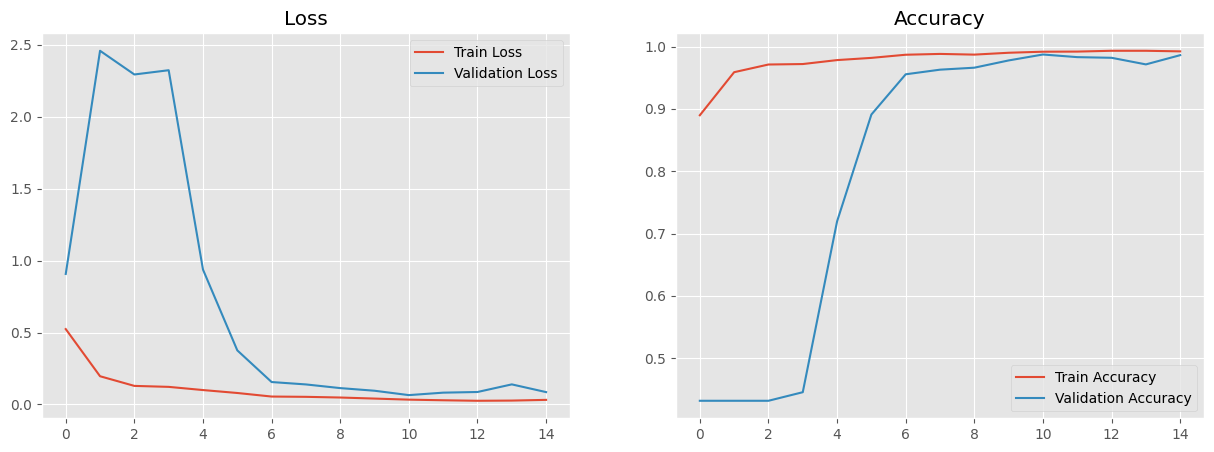

In [37]:
objDraw.draw_history(hist)

In [41]:
model.save('model.h5')

# Evaluate

22/22 [==============================] - 1s 14ms/step


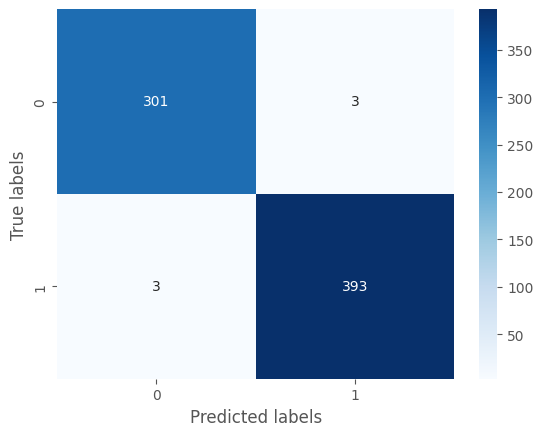

In [38]:
y_pred = model.predict(xGauss_test)

y_pred_classes = np.argmax(y_pred, axis=1)
confusion_Matrix = confusion_matrix(yGauss_test, y_pred_classes)
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues',fmt='.3g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [39]:
print(classification_report(yGauss_test, y_pred_classes))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       304
           1       0.99      0.99      0.99       396

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700



1/1 [==============================] - 0s 53ms/step


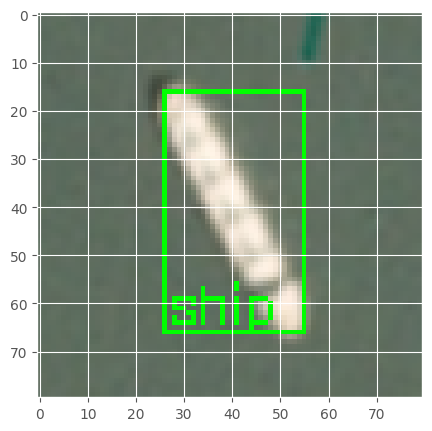

In [59]:
TestFunction(r'/content/satallite_Dataset/ship/ship_000090.png')

1/1 [==============================] - 0s 66ms/step


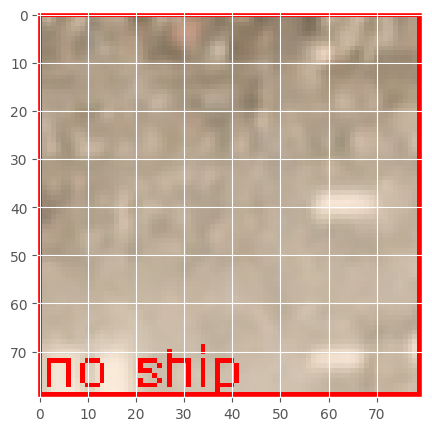

In [82]:
TestFunction(r'/content/satallite_Dataset/no-ship/no-ship_002000.png')

<hr>
<hr>
<hr>